# I.Import Librairies

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
!pip install pyproj==1.9.6
!apt-get install -q libgeos-3.5.0
!apt-get install -q libgeos-dev
!pip install -q https://github.com/matplotlib/basemap/archive/master.zip
!pip install -q pyproj==1.9.6

!pip install pyspellchecker
!pip install emoji
!pip install spacy

Reading package lists...
Building dependency tree...
Reading state information...
E: Unable to locate package libgeos-3.5.0
E: Couldn't find any package by glob 'libgeos-3.5.0'
E: Couldn't find any package by regex 'libgeos-3.5.0'
Reading package lists...
Building dependency tree...
Reading state information...
libgeos-dev is already the newest version (3.6.2-1build2).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import re
from geopy.geocoders import Nominatim
from datetime import date
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from scipy.cluster.vq import kmeans,vq
from mpl_toolkits.basemap import Basemap
import collections
import os
import string
import sys
import scipy
import spellchecker
import emoji
import spacy
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('words')
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
from wordcloud import WordCloud, STOPWORDS

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "



# II. Definition of useful functions

In [ ]:
def get_original_data():
  df1 = pd.read_csv('/content/drive/My Drive/Data Mining Project/Final Files/Data/data_1.csv', engine='python' )
  df2 = pd.read_csv('/content/drive/My Drive/Data Mining Project/Final Files/Data/data_2.csv', engine='python' )
  df3 = pd.read_csv('/content/drive/My Drive/Data Mining Project/Final Files/Data/data_3.csv', engine='python' )
  df4 = pd.read_csv('/content/drive/My Drive/Data Mining Project/Final Files/Data/data_4.csv', engine='python' )
  df5 = pd.read_csv('/content/drive/My Drive/Data Mining Project/Final Files/Data/data_5.csv', engine='python' )
  df6 = pd.read_csv('/content/drive/My Drive/Data Mining Project/Final Files/Data/data_6.csv', engine='python' )
  frames = [df1, df2, df3, df4, df5, df6]
  df = pd.concat(frames)
  return df 

In [ ]:
def get_cleaned_data():
  # Get original dataset
  df = get_original_data()

  # Drop null values
  df = df.dropna()

  # Filter on dates that are usable
  df = df.loc[df['Date'].apply(lambda x : len(x)) ==10]
  df['Date'] = pd.to_datetime(df['Date'])

  # Change the type of User Created_At to date
  df['User Created_At'] = pd.to_datetime(df['User Created_At'])
  df['Created_At'] = pd.to_datetime(df['Created_At'])

  # Clean boolean features 

  dico_bool ={ 'False': False, 'True': True, False: False, True: True}
  df["Verified"] = df['Verified'].apply(lambda x : dico_bool[x])
  df['Retweeted.1'] = df['Retweeted.1'].apply(lambda x : dico_bool[x])
  df['Retweeted'] = df['Retweeted'].apply(lambda x : dico_bool[x])

  return df

In [ ]:
def get_enriched_data():
  df = get_cleaned_data()

  # Add geographic features
  loc = pd.read_csv('/content/drive/My Drive/Data Mining Project/Final Files/Data/Location_enriched.csv')
  df = df.merge(loc, how = 'left', on = 'Location')

  # Add dates features
  column_dates = ['Date', 'User Created_At', 'Created_At']

  today = date.today()

  for col in column_dates: 
    df['Age of '+ col] = (today - pd.to_datetime(df[col]).apply(lambda x: x.date()) )
    df['Weekday of '+ col ] = pd.to_datetime(df[col]).apply(lambda x: x.weekday())
    df['Month of '+ col ] = pd.to_datetime(df[col]).apply(lambda x: x.month)                                                  
 
  return df 

In [ ]:
def repartition (column):
  df_repartition = df[column].value_counts().reset_index()
  print("The number of unique values of ", column, " is: ", len(df_repartition))
  df_repartition.columns  = [column, "Number of Tweets"]
  df_repartition[column] = df_repartition[column].apply(lambda x: str(x))
  df_repartition["Number of Tweets"] = df_repartition["Number of Tweets"]
  fig = plt.figure(figsize=(20,20))
  sns.barplot(x = 'Number of Tweets',  y = column, data = df_repartition.head(40), palette = "flare");
  plt.title('Occurence of top values of ' +str( column))
  plt.show()
  print(df_repartition.head(20))

In [ ]:
def repartition_in_percentage (column):
  df_repartition = df[column].value_counts().reset_index()
  print("The number of unique values of ", column, " is: ", len(df_repartition))
  df_repartition.columns  = [column, "Percentage of Tweets"]
  df_repartition[column] = df_repartition[column].apply(lambda x: str(x))
  fig = plt.figure(figsize=(20,20))
  df_repartition["Percentage of Tweets"] = df_repartition["Percentage of Tweets"]/len(df)*100
  sns.barplot(x = 'Percentage of Tweets',  y = column, data = df_repartition.head(40), palette = "flare");
  plt.title('Percentatge of top values of ' + str(column))
  plt.show()
  print(df_repartition.head(20))

In [ ]:
def distributions():
  numeric_columns = df._get_numeric_data().columns
  for f in numeric_columns: 
    plt.figure(figsize=(10,5))
    sns.kdeplot(data = df, x = f, color="pink", bw_adjust=5, fill=True)
    plt.title('Distribution of '+f)
    plt.show()


In [ ]:
def box_plots(df):
  numeric_columns = df._get_numeric_data().columns
  for f in numeric_columns: 
    sns.boxplot(x = f , data = df, palette = "flare");
    plt.title("Repartition of "+ f)
    plt.show()
    print("The detailed description is the following")
    print(df[f].describe())
    print()

# III. Determination of groups of similar users

The objective of this part is to determine if there are some groups of simil

The Id is the integer representation of the unique identifier for a twitter user. So it is the variable used to study a user and its popularity.

##### A. Explanation of the method 

In order to determine the groups of similar users, I would like to focus on three main points: 
- The popularity of the user 
- The amount of interaction of the user 
- The location of the user

For the popularity, I would like to focus on two variables: the number of followers, and the number of friends, because they are good indicators of the social network and the impact of the user on the platform. 

For what concerns the interaction of the user, I chose to take into account the time spent on the platform by the user based on the creation date of the account, and the number of favourites count, which is the number of posts liked by hte user.

Finally, in order to take into account th potential cultural, and social aspects of the users, I considered also the latitude and longitude of the user in order to give a and information about its locatin. I chose note to consider the country , but the latitude and longitude because i do note wand the definition of proximity by user that will be lost when choosing the country (categorical feature). 

For all the criteria specified above, I will apply a PCA on these features, so I will end up with three axes of variance repesenting respectively : the popularity, the interaction of the user with the platform, and the geographic repartition. 

Then I will apply a clustering to these three features in order to determine groups of users with similar behaviors. 

## B. Building the clustering features

##### Choice of features 


In [ ]:
popularity_features = ['Followers_Count', 'Friends_Count','Verified']
interaction_features = ['Favourites_Count',  'Age of User Created_At']
geo_features = ['Latitude', 'Longitude']

In [ ]:
all_features =  ['Id'] + popularity_features + interaction_features + geo_features 

##### Creation of users dataset

In [ ]:
users = get_enriched_data()
users = users.dropna()

###### Transformation of features

In [ ]:
users['Age of User Created_At'] =users['Age of User Created_At'].apply(lambda x : int(str(x)[:-14]) if x != np.NaN  and x != '' else '')

###### Aggregate information by user 

In [ ]:
users = users.groupby(['Id']).agg('mean')
users.reset_index(inplace = True)

In [ ]:
clustering_data = users[all_features]
clustering_data

,Id,Followers_Count,Friends_Count,Verified,Favourites_Count,Age of User Created_At,Latitude,Longitude
0,1336391341069234176,645.0,1635.0,0.0,16840.0,1301,52.500170,5.748082
1,1336391341148762112,127586.0,1798.0,1.0,575.0,4065,55.001251,-125.002441
2,1336391342734323717,357.0,250.0,0.0,6906.0,2186,38.414733,27.143412
3,1336391342788931585,178.0,1215.0,0.0,15181.0,3485,41.796241,-71.599237
4,1336391343166328832,5.0,67.0,0.0,501.0,70,55.860982,-4.248879
...,...,...,...,...,...,...,...,...
982160,1336680117431627777,172.0,325.0,0.0,574.0,36,56.786111,-4.114052
982161,1336680117947551749,21465.0,446.0,0.0,219.0,2171,9.600036,7.999972
982162,1336680119516065793,29.0,147.0,0.0,2713.0,938,19.587268,-155.426890
982163,1336680120443138051,743.0,934.0,0.0,8939.0,862,53.349764,-6.260273


##### Dimension reduction by group of features

###### Application of PCA on popularity features 

In [ ]:
X = clustering_data[popularity_features]
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
pca = PCA(n_components=1)
pca.fit(X)
print("The variance explained is", pca.explained_variance_ratio_[0])

The variance explained is 0.4029243210967617


In [ ]:
popularity_axis = pca.fit_transform(X)

###### Application of PCA on interraction features

In [ ]:
X = clustering_data[interaction_features]
scaler = StandardScaler()
scaler.fit(X)
pca = PCA(n_components=1)
pca.fit(X)
print("The variance explained is", pca.explained_variance_ratio_[0])

The variance explained is 0.9992616477114835


In [ ]:
interaction_axis = pca.fit_transform(X)

###### Application of PCA on geographic features

In [ ]:
X = clustering_data[geo_features]
scaler = StandardScaler()
scaler.fit(X)
pca = PCA(n_components=1)
pca.fit(X)
print("The variance explained is", pca.explained_variance_ratio_[0])

The variance explained is 0.9495587548545686


In [ ]:
geo_axis = pca.fit_transform(X)

##### Introduction of clustering features into the dataset

In [ ]:
clustering_data["Popularity"] = popularity_axis
clustering_data["Interaction"] = interaction_axis
clustering_data["Geo"] = geo_axis
clustering_data

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

,Id,Followers_Count,Friends_Count,Verified,Favourites_Count,Age of User Created_At,Latitude,Longitude,Popularity,Interaction,Geo
0,1336391341069234176,645.0,1635.0,0.0,16840.0,1301,52.500170,5.748082,-0.415028,-2486.385322,54.361599
1,1336391341148762112,127586.0,1798.0,1.0,575.0,4065,55.001251,-125.002441,1.462403,-18749.364397,-75.796879
2,1336391342734323717,357.0,250.0,0.0,6906.0,2186,38.414733,27.143412,-0.422427,-12419.736988,77.245952
3,1336391342788931585,178.0,1215.0,0.0,15181.0,3485,41.796241,-71.599237,-0.417459,-4143.791449,-21.222679
4,1336391343166328832,5.0,67.0,0.0,501.0,70,55.860982,-4.248879,-0.423559,-18826.279103,44.042357
...,...,...,...,...,...,...,...,...,...,...,...
982160,1336680117431627777,172.0,325.0,0.0,574.0,36,56.786111,-4.114052,-0.422125,-18753.303929,44.068996
982161,1336680117947551749,21465.0,446.0,0.0,219.0,2171,9.600036,7.999972,-0.411006,-19106.746152,61.573038
982162,1336680119516065793,29.0,147.0,0.0,2713.0,938,19.587268,-155.426890,-0.423128,-16613.646405,-101.909438
982163,1336680120443138051,743.0,934.0,0.0,8939.0,862,53.349764,-6.260273,-0.418653,-10387.703511,42.335735


In [ ]:
clustering_data

,Id,Followers_Count,Friends_Count,Verified,Favourites_Count,Age of User Created_At,Latitude,Longitude,Popularity,Interaction,Geo
0,1336391341069234176,645.0,1635.0,0.0,16840.0,1301,52.500170,5.748082,-0.415028,-2486.385322,54.361599
1,1336391341148762112,127586.0,1798.0,1.0,575.0,4065,55.001251,-125.002441,1.462403,-18749.364397,-75.796879
2,1336391342734323717,357.0,250.0,0.0,6906.0,2186,38.414733,27.143412,-0.422427,-12419.736988,77.245952
3,1336391342788931585,178.0,1215.0,0.0,15181.0,3485,41.796241,-71.599237,-0.417459,-4143.791449,-21.222679
4,1336391343166328832,5.0,67.0,0.0,501.0,70,55.860982,-4.248879,-0.423559,-18826.279103,44.042357
...,...,...,...,...,...,...,...,...,...,...,...
982160,1336680117431627777,172.0,325.0,0.0,574.0,36,56.786111,-4.114052,-0.422125,-18753.303929,44.068996
982161,1336680117947551749,21465.0,446.0,0.0,219.0,2171,9.600036,7.999972,-0.411006,-19106.746152,61.573038
982162,1336680119516065793,29.0,147.0,0.0,2713.0,938,19.587268,-155.426890,-0.423128,-16613.646405,-101.909438
982163,1336680120443138051,743.0,934.0,0.0,8939.0,862,53.349764,-6.260273,-0.418653,-10387.703511,42.335735


#### Normalize the clustering features 

Here we will normalize the axis, so the variabtion of each feature is comparable to the other. 

In [ ]:
clustering_axis = ['Popularity', "Interaction", 'Geo']
scaler = StandardScaler()
scaler.fit(clustering_data[clustering_axis])
normalized_clustering_data = scaler.transform(clustering_data[clustering_axis])
normalized_clustering_data =  pd.DataFrame(normalized_clustering_data, columns = clustering_axis)

In [ ]:
normalized_clustering_data.head()

,Popularity,Interaction,Geo
0,-0.377490,-0.046539,0.793207
1,1.330132,-0.350945,-1.105976
2,-0.384219,-0.232469,1.127120
3,-0.379701,-0.077562,-0.309667
4,-0.385249,-0.352385,0.642636


In [ ]:
weighted_clustering_data= normalized_clustering_data.copy()

#### Plots in 3D of normalized clustering features

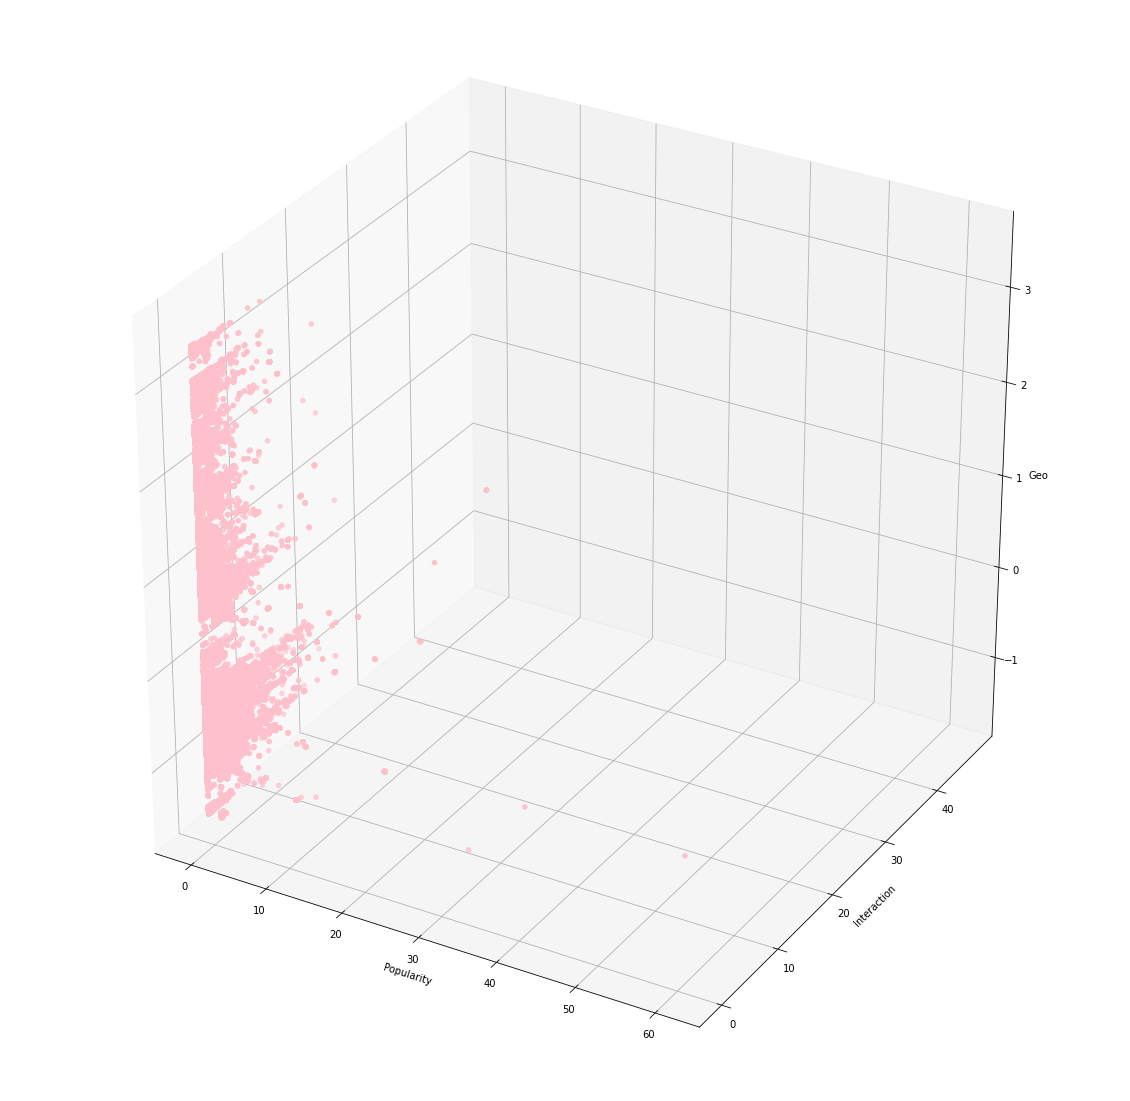

In [ ]:
fig = plt.figure(figsize=(20, 20))

ax = fig.add_subplot(111, projection='3d')

ax.scatter(normalized_clustering_data["Popularity"], 
           normalized_clustering_data['Interaction'], 
           normalized_clustering_data['Geo'], 
           c='pink')

ax.set_xlabel('Popularity')
ax.set_ylabel('Interaction')
ax.set_zlabel('Geo')
plt.show()

We can see in this plot that the geo feature is the one that presents the biggest variation. However, it seems to me that one of the most imporant features in determining clusters of similar users are popularity and interraction. So in the next part, we will try to weight these factors in order to make them more important in our clustering. 

In [ ]:
users['Popularity Normalized'] =  popularity_axis
users['Interaction Normalized']  = interaction_axis
users["Geo Normalized"] = geo_axis

#### Weight of clustering features in function of their importance

In [ ]:
weight_coeff = [10, 3, 1]

In [ ]:
dico_weight = dict(zip(clustering_axis, weight_coeff))

In [ ]:
weighted_clustering_data

,Popularity,Interaction,Geo
0,-0.377490,-0.046539,0.793207
1,1.330132,-0.350945,-1.105976
2,-0.384219,-0.232469,1.127120
3,-0.379701,-0.077562,-0.309667
4,-0.385249,-0.352385,0.642636
...,...,...,...
982160,-0.383945,-0.351019,0.643025
982161,-0.373832,-0.357635,0.898432
982162,-0.384857,-0.310969,-1.486993
982163,-0.380787,-0.194434,0.617734


In [ ]:
for f in weighted_clustering_data:
  weighted_clustering_data[f] = weighted_clustering_data[f] * dico_weight[f]

In [ ]:
users['Popularity Weighted'] =  popularity_axis
users['Interaction Weighted']  = interaction_axis
users["Geo Weighted"] = geo_axis

#### Plots in 3D of weighted clustering features

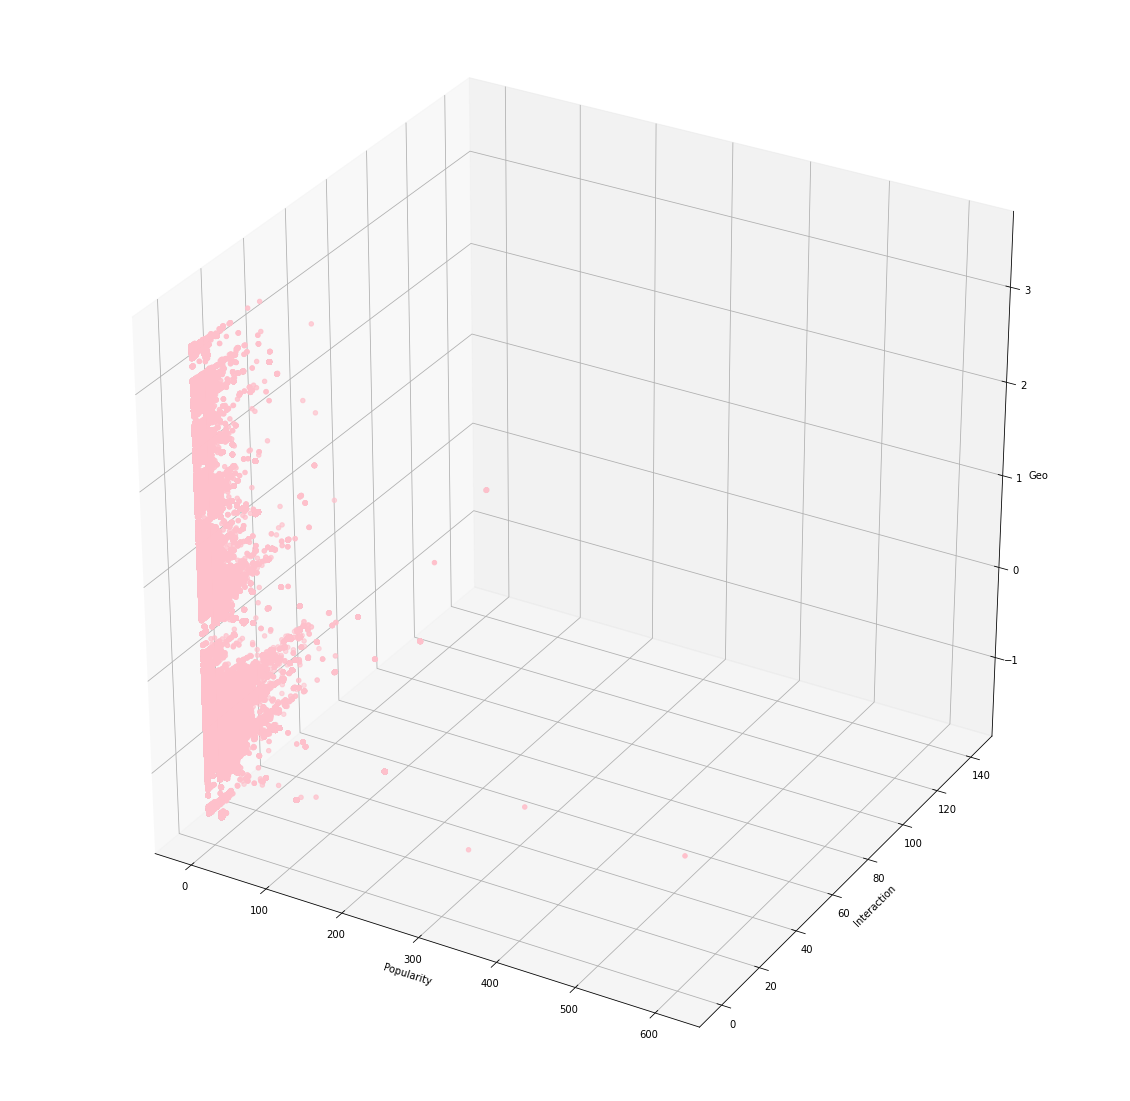

In [ ]:
fig = plt.figure(figsize=(20, 20))

ax = fig.add_subplot(111, projection='3d')

ax.scatter(weighted_clustering_data["Popularity"], 
           weighted_clustering_data['Interaction'], 
           weighted_clustering_data['Geo'], 
           c='pink')

ax.set_xlabel('Popularity')
ax.set_ylabel('Interaction')
ax.set_zlabel('Geo')

plt.show()

## C. Application of Kmeans algorithms on normalized clustering features 

##### Train Kmeans with multiple k 

In [ ]:
distortions = []
list_k = [i for i in range(1,15)]
for k in list_k :
  model = KMeans(n_clusters = k, init='k-means++' )
  model.fit(normalized_clustering_data)
  distortions.append(model.inertia_)

##### Plots of distortions to determine the best k

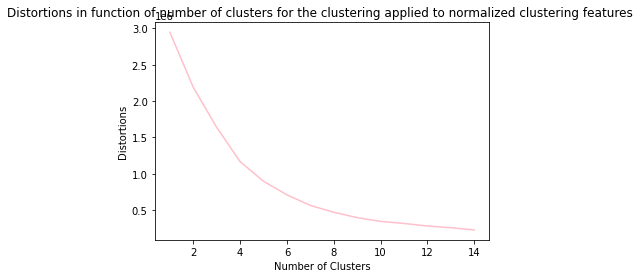

In [ ]:
elbow_data = pd.DataFrame({'Number of clusters':list_k ,'Distortions':distortions})
sns.lineplot(x='Number of clusters', y='Distortions', data = elbow_data, color = 'pink')
plt.title('Distortions in function of number of clusters for the clustering applied to normalized clustering features ')
plt.xlabel('Number of Clusters')
plt.ylabel("Distortions")
plt.show()

Here we have chosen k = 4.

In [ ]:
k = 4

#### Determine cluster centers and labels

In [ ]:
model = KMeans(n_clusters = k, init='k-means++')
model.fit(normalized_clustering_data)
normalized_clustering_data["Kmean Labels"] = model.predict(normalized_clustering_data)
cluster_centers_km_nm = model.cluster_centers_

In [ ]:
normalized_clustering_data.head()

,Popularity,Interaction,Geo,Kmean Labels
0,-0.377490,-0.046539,0.793207,0
1,1.330132,-0.350945,-1.105976,3
2,-0.384219,-0.232469,1.127120,0
3,-0.379701,-0.077562,-0.309667,1
4,-0.385249,-0.352385,0.642636,0


#### Analysis of centroids

In [ ]:
columns = list(normalized_clustering_data.columns)[:3]
print("The center of clusters are: ")
cluster_centers_km_nm
cluster_centers = pd.DataFrame(cluster_centers_km_nm)
cluster_centers.columns = columns
cluster_centers['Occurence']  =normalized_clustering_data["Kmean Labels"].value_counts()
cluster_centers

The center of clusters are: 


,Popularity,Interaction,Geo,Occurence
0,-0.250530,-0.137901,1.306556,274607
1,-0.372735,-0.064691,-0.615811,522539
2,-0.281228,4.995388,-0.276120,22031
3,1.655089,-0.236263,-0.189742,162988


#### Add labels to users dataset 

In [ ]:
users.head()

,Id,Followers_Count,Friends_Count,Favourites_Count,Verified,Favorite_Count,Retweeted,Reply_Count,Retweet_Count,Retweeted.1,Unnamed: 0_y,Latitude,Longitude,Weekday of Date,Month of Date,Age of User Created_At,Weekday of User Created_At,Month of User Created_At,Weekday of Created_At,Month of Created_At,Popularity Normalized,Interaction Normalized,Geo Normalized,Popularity Weighted,Interaction Weighted,Geo Weighted
0,1336391341069234176,645.0,1635.0,16840.0,0.0,0.0,0.0,0.0,0.0,0.0,263.0,52.500170,5.748082,1,12,1301,2,6,1,12,-0.415028,-2486.385322,54.361599,-0.415028,-2486.385322,54.361599
1,1336391341148762112,127586.0,1798.0,575.0,1.0,0.0,0.0,0.0,0.0,0.0,150.0,55.001251,-125.002441,1,12,4065,3,11,1,12,1.462403,-18749.364397,-75.796879,1.462403,-18749.364397,-75.796879
2,1336391342734323717,357.0,250.0,6906.0,0.0,0.0,0.0,0.0,0.0,0.0,4909.0,38.414733,27.143412,1,12,2186,6,1,1,12,-0.422427,-12419.736988,77.245952,-0.422427,-12419.736988,77.245952
3,1336391342788931585,178.0,1215.0,15181.0,0.0,1.0,0.0,0.0,0.0,0.0,3000.0,41.796241,-71.599237,1,12,3485,2,6,1,12,-0.417459,-4143.791449,-21.222679,-0.417459,-4143.791449,-21.222679
4,1336391343166328832,5.0,67.0,501.0,0.0,0.0,0.0,0.0,0.0,0.0,130.0,55.860982,-4.248879,1,12,70,1,10,1,12,-0.423559,-18826.279103,44.042357,-0.423559,-18826.279103,44.042357


In [ ]:
users['Normalized Cluster'] = normalized_clustering_data["Kmean Labels"]

### Analysis of cluster centers 

In [ ]:
comparison_columns = ['Followers_Count', 'Friends_Count',
       'Favourites_Count', 'Verified','Favorite_Count',
       'Latitude', 'Longitude','Age of User Created_At']

In [ ]:
tab = users.groupby('Normalized Cluster').agg("mean")[comparison_columns]
tab.reset_index(inplace = True)
tab = tab.dropna()

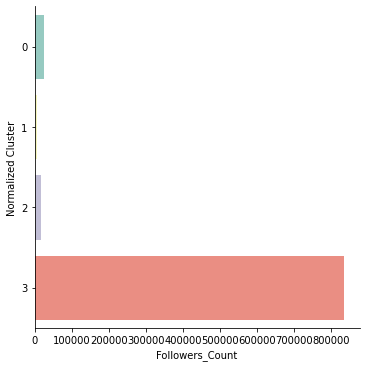

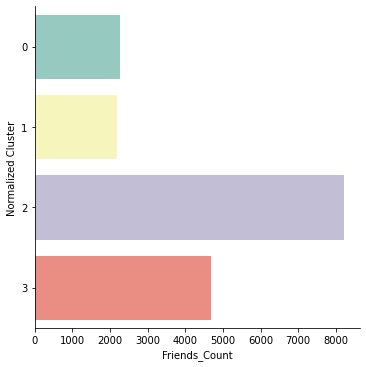

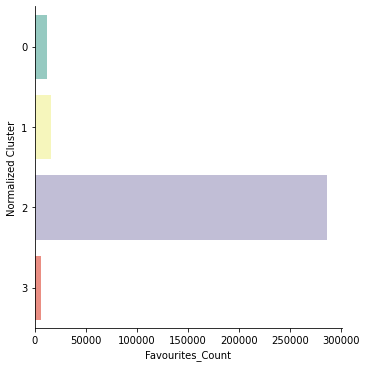

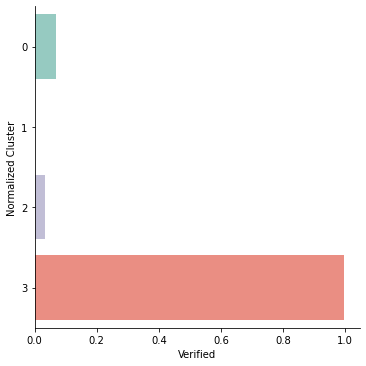

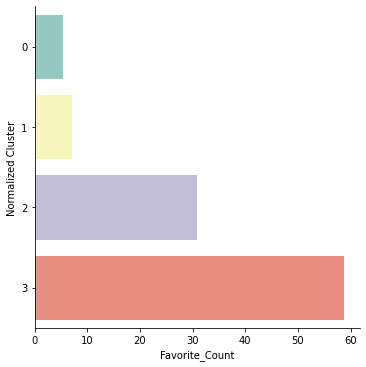

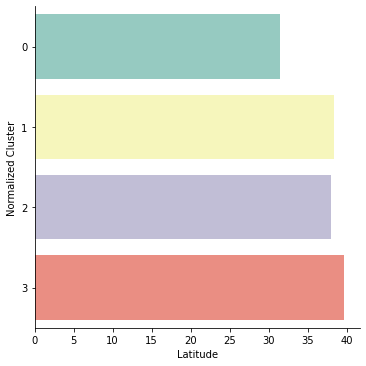

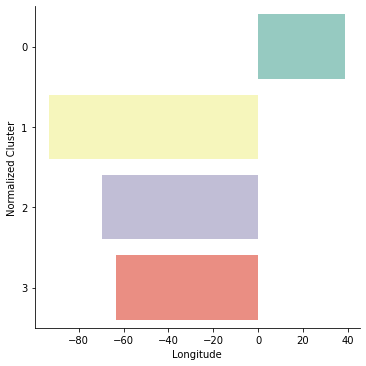

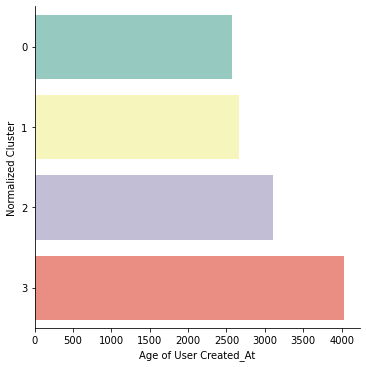

In [ ]:
for col in list(tab.columns[1:]): 
    sns.catplot(x = str(col), y = 'Normalized Cluster',  data =tab, orient= "h",  kind="bar", palette = "Set3")
    plt.show()

In [ ]:
users['Normalized Cluster'].value_counts()

1    522539
0    274607
3    162988
2     22031
Name: Normalized Cluster, dtype: int64

## D. Application of Kmeans algorithm on weighted clustering features 

##### Train Kmeans with multiple k 

In [ ]:
weighted_clustering_data.head()

,Popularity,Interaction,Geo
0,-3.774898,-0.139618,0.793207
1,13.301317,-1.052836,-1.105976
2,-3.842194,-0.697407,1.127120
3,-3.797006,-0.232687,-0.309667
4,-3.852492,-1.057155,0.642636


In [ ]:
distortions = []
list_k = [i for i in range(1,15)]

for k in list_k :
  model = KMeans(n_clusters = k, init='k-means++')
  model.fit(weighted_clustering_data)
  distortions.append(model.inertia_)

##### Plots of distortions to determine the best k

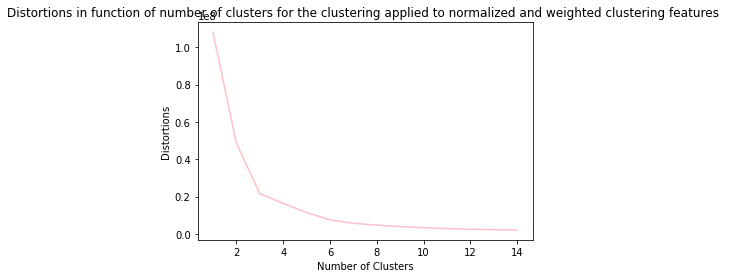

In [ ]:
elbow_data_w = pd.DataFrame({'Number of clusters':list_k ,'Distortions':distortions})
sns.lineplot(x='Number of clusters', y='Distortions', data = elbow_data_w, color = 'pink')
plt.title('Distortions in function of number of clusters for the clustering applied to normalized and weighted clustering features ')
plt.xlabel('Number of Clusters')
plt.ylabel("Distortions")
plt.show()

Here we have chosen k = 4.

In [ ]:
k = 3

In [ ]:
weighted_clustering_data.head()

,Popularity,Interaction,Geo
0,-3.774898,-0.139618,0.793207
1,13.301317,-1.052836,-1.105976
2,-3.842194,-0.697407,1.127120
3,-3.797006,-0.232687,-0.309667
4,-3.852492,-1.057155,0.642636


#### Determine cluster centers and labels

In [ ]:
model = KMeans(n_clusters = k, init='k-means++')
model.fit(weighted_clustering_data)

weighted_clustering_data["Kmean Labels"] = model.predict(weighted_clustering_data)
cluster_centers_km_weighted = model.cluster_centers_

In [ ]:
cluster_centers_km_weighted 

array([[-3.71442217e+00,  1.49484936e-01, -1.43736957e-02],
       [ 1.46947628e+01, -6.49801909e-01,  6.61759967e-02],
       [ 1.11421029e+02, -9.17046484e-01, -1.37400643e-01]])

#### Analysis of centroids

In [ ]:
columns = list(weighted_clustering_data.columns)[:3]
print("The center of clusters are: ")
print(columns)
#cluster_centers_km_weighted 
cluster_centers_weighted = pd.DataFrame(cluster_centers_km_weighted)
cluster_centers_weighted.columns = columns
cluster_centers_weighted ['Occurence']  = weighted_clustering_data[ "Kmean Labels"].value_counts()
cluster_centers_weighted 

The center of clusters are: 
['Popularity', 'Interaction', 'Geo']


,Popularity,Interaction,Geo,Occurence
0,-3.714422,0.149485,-0.014374,799462
1,14.694763,-0.649802,0.066176,179759
2,111.421029,-0.917046,-0.137401,2944


#### Add labels to users dataset 

In [ ]:
users['Weighted Cluster'] = weighted_clustering_data[ "Kmean Labels"]

### Analysis of cluster centers

### Description of users data by cluster 

In [ ]:
cluster_0_w = users[users['Weighted Cluster']==0]
cluster_1_w = users[users['Weighted Cluster']==1]
cluster_2_w = users[users['Weighted Cluster']==2]

In [ ]:
cluster_0 = users[users['Normalized Cluster']==0]
cluster_1 = users[users['Normalized Cluster']==1]
cluster_2 = users[users['Normalized Cluster']==2]
cluster_3 = users[users['Normalized Cluster']==3]

In [ ]:
comparison_columns = ['Followers_Count', 'Friends_Count',
       'Favourites_Count', 'Verified','Favorite_Count',
       'Latitude', 'Longitude','Age of User Created_At']

In [ ]:
#users['Weighted Cluster'].value_counts()

In [ ]:
tab = users.groupby('Weighted Cluster').agg("mean")[comparison_columns]
tab.reset_index(inplace = True)
tab = tab.dropna()

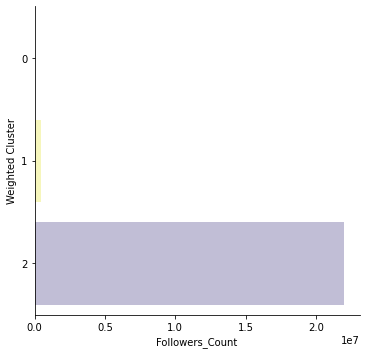

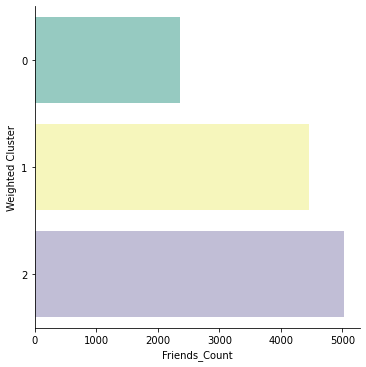

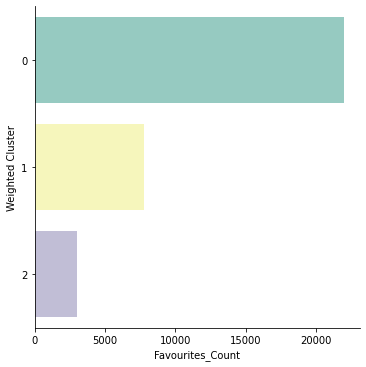

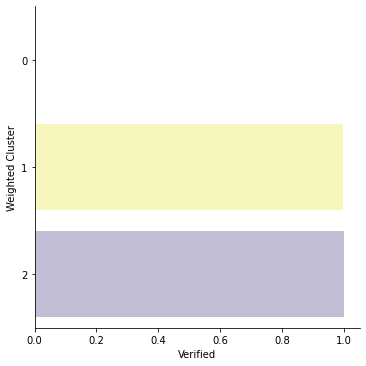

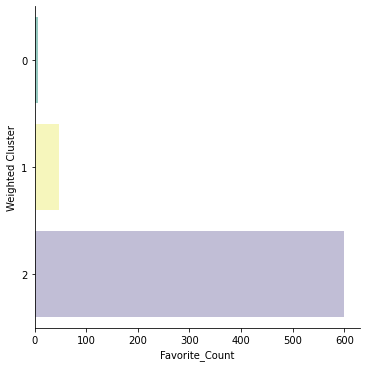

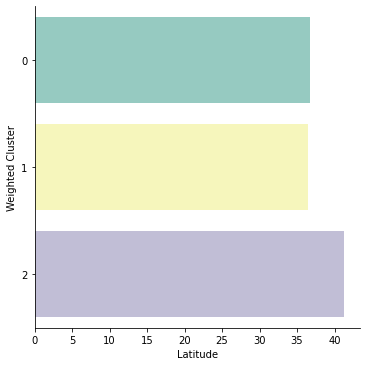

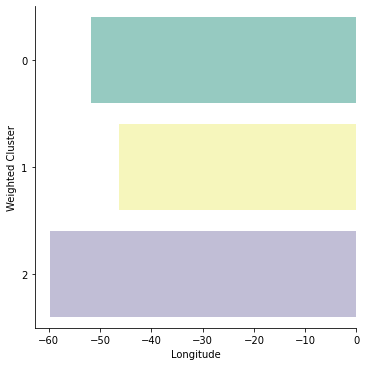

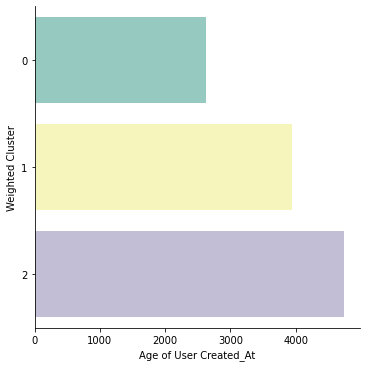

In [ ]:
for col in list(tab.columns[1:]): 
    sns.catplot(x = str(col), y = 'Weighted Cluster',  data =tab, orient= "h",  kind="bar", palette = "Set3")
    plt.show()

In [ ]:
cluster_0_w.describe()

,Followers_Count,Friends_Count,Favourites_Count,Verified,Favorite_Count,Retweeted,Reply_Count,Retweet_Count,Retweeted.1,Unnamed: 0_y,Latitude,Longitude,Weekday of Date,Month of Date,Age of User Created_At,Weekday of User Created_At,Month of User Created_At,Weekday of Created_At,Month of Created_At,Popularity Normalized,Interaction Normalized,Geo Normalized,Popularity Weighted,Interaction Weighted,Geo Weighted,Normalized Cluster,Weighted Cluster
count,7.994620e+05,799462.000000,7.994620e+05,799462.000000,799462.000000,799462.0,799462.0,799462.000000,799462.0,799462.000000,799462.000000,799462.000000,799462.000000,799462.000000,799462.000000,799462.000000,799462.000000,799462.000000,799462.000000,799462.000000,7.994620e+05,799462.000000,799462.000000,7.994620e+05,799462.000000,799462.000000,799462.0
mean,6.381987e+03,2364.395746,2.198751e+04,0.000001,6.493731,0.0,0.0,1.341771,0.0,694.446212,36.697117,-51.819504,1.601798,11.669076,2626.680496,2.799987,6.235695,1.601798,11.669076,-0.408379,2.662094e+03,-0.985086,-0.408379,2.662094e+03,-0.985086,0.706692,0.0
std,4.109442e+04,7278.973675,5.738001e+04,0.000791,539.519513,0.0,0.0,115.914551,0.0,1146.500406,17.820626,67.446023,1.364537,0.470546,1441.641739,1.949902,3.361845,1.364537,0.470546,0.046546,5.738007e+04,67.883804,0.046546,5.738007e+04,67.883804,0.510343,0.0
min,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,-79.406307,-157.855676,0.000000,11.000000,20.000000,0.000000,1.000000,0.000000,11.000000,-0.423913,-1.932732e+04,-104.520977,-0.423913,-1.932732e+04,-104.520977,0.000000,0.0
25%,1.700000e+02,232.000000,4.820000e+02,0.000000,0.000000,0.0,0.0,0.000000,0.0,27.000000,33.750038,-99.512099,1.000000,11.000000,1369.000000,1.000000,3.000000,1.000000,11.000000,-0.422325,-1.884405e+04,-47.789920,-0.422325,-1.884405e+04,-47.789920,0.000000,0.0
50%,7.540000e+02,668.000000,3.767000e+03,0.000000,0.000000,0.0,0.0,0.000000,0.0,150.000000,39.783730,-78.890041,1.000000,12.000000,2934.000000,3.000000,6.000000,1.000000,12.000000,-0.419305,-1.555825e+04,-27.845396,-0.419305,-1.555825e+04,-27.845396,1.000000,0.0
75%,3.039000e+03,1931.000000,1.832600e+04,0.000000,1.000000,0.0,0.0,0.000000,0.0,771.000000,45.709097,-1.991194,2.000000,12.000000,3945.000000,4.000000,9.000000,2.000000,12.000000,-0.411305,-9.988500e+02,46.700591,-0.411305,-9.988500e+02,46.700591,1.000000,0.0
max,1.893300e+06,187719.000000,2.554744e+06,0.500000,335069.000000,0.0,0.0,73993.000000,0.0,5304.000000,90.000000,179.012274,6.000000,12.000000,5284.000000,6.000000,12.000000,6.000000,12.000000,0.648579,2.535419e+06,234.646554,0.648579,2.535419e+06,234.646554,2.000000,0.0


# Stop 


# IV. Application of Hierarchichal clustering

## A. Building the clustering features

##### Choice of features 


In [ ]:
popularity_features = ['Followers_Count', 'Friends_Count','Verified']
interaction_features = ['Favourites_Count',  'Age of User Created_At']
geo_features = ['Latitude', 'Longitude']

In [ ]:
all_features =  ['Id'] + popularity_features + interaction_features + geo_features 

##### Creation of users dataset

In [ ]:
users = get_enriched_data()
users = users.dropna()

###### Transformation of features

In [ ]:
users['Age of User Created_At'] =users['Age of User Created_At'].apply(lambda x : int(str(x)[:-14]) if x != np.NaN  and x != '' else '')

###### Aggregate information by user 

In [ ]:
users = users.groupby(['Id']).agg('mean')
users.reset_index(inplace = True)

In [ ]:
clustering_data = users[all_features]
clustering_data

,Id,Followers_Count,Friends_Count,Verified,Favourites_Count,Age of User Created_At,Latitude,Longitude
0,1336391341069234176,645.0,1635.0,0.0,16840.0,1301,52.500170,5.748082
1,1336391341148762112,127586.0,1798.0,1.0,575.0,4065,55.001251,-125.002441
2,1336391342734323717,357.0,250.0,0.0,6906.0,2186,38.414733,27.143412
3,1336391342788931585,178.0,1215.0,0.0,15181.0,3485,41.796241,-71.599237
4,1336391343166328832,5.0,67.0,0.0,501.0,70,55.860982,-4.248879
...,...,...,...,...,...,...,...,...
982160,1336680117431627777,172.0,325.0,0.0,574.0,36,56.786111,-4.114052
982161,1336680117947551749,21465.0,446.0,0.0,219.0,2171,9.600036,7.999972
982162,1336680119516065793,29.0,147.0,0.0,2713.0,938,19.587268,-155.426890
982163,1336680120443138051,743.0,934.0,0.0,8939.0,862,53.349764,-6.260273


##### Dimension reduction by group of features

###### Application of PCA on popularity features 

In [ ]:
X = clustering_data[popularity_features]
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
pca = PCA(n_components=1)
pca.fit(X)
print("The variance explained is", pca.explained_variance_ratio_[0])

The variance explained is 0.40292432109676213


In [ ]:
popularity_axis = pca.fit_transform(X)

###### Application of PCA on interraction features

In [ ]:
X = clustering_data[interaction_features]
scaler = StandardScaler()
scaler.fit(X)
pca = PCA(n_components=1)
pca.fit(X)
print("The variance explained is", pca.explained_variance_ratio_[0])

The variance explained is 0.9992616477114816


In [ ]:
interaction_axis = pca.fit_transform(X)

###### Application of PCA on geographic features

In [ ]:
X = clustering_data[geo_features]
scaler = StandardScaler()
scaler.fit(X)
pca = PCA(n_components=1)
pca.fit(X)
print("The variance explained is", pca.explained_variance_ratio_[0])

The variance explained is 0.9495587548545729


In [ ]:
geo_axis = pca.fit_transform(X)

##### Introduction of clustering features into the dataset

In [ ]:
clustering_data["Popularity"] = popularity_axis
clustering_data["Interaction"] = interaction_axis
clustering_data["Geo"] = geo_axis
clustering_data

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

,Id,Followers_Count,Friends_Count,Verified,Favourites_Count,Age of User Created_At,Latitude,Longitude,Popularity,Interaction,Geo
0,1336391341069234176,645.0,1635.0,0.0,16840.0,1301,52.500170,5.748082,-0.415028,-2486.385322,54.361599
1,1336391341148762112,127586.0,1798.0,1.0,575.0,4065,55.001251,-125.002441,1.462403,-18749.364397,-75.796879
2,1336391342734323717,357.0,250.0,0.0,6906.0,2186,38.414733,27.143412,-0.422427,-12419.736988,77.245952
3,1336391342788931585,178.0,1215.0,0.0,15181.0,3485,41.796241,-71.599237,-0.417459,-4143.791449,-21.222679
4,1336391343166328832,5.0,67.0,0.0,501.0,70,55.860982,-4.248879,-0.423559,-18826.279103,44.042357
...,...,...,...,...,...,...,...,...,...,...,...
982160,1336680117431627777,172.0,325.0,0.0,574.0,36,56.786111,-4.114052,-0.422125,-18753.303929,44.068996
982161,1336680117947551749,21465.0,446.0,0.0,219.0,2171,9.600036,7.999972,-0.411006,-19106.746152,61.573038
982162,1336680119516065793,29.0,147.0,0.0,2713.0,938,19.587268,-155.426890,-0.423128,-16613.646405,-101.909438
982163,1336680120443138051,743.0,934.0,0.0,8939.0,862,53.349764,-6.260273,-0.418653,-10387.703511,42.335735


In [ ]:
clustering_data

,Id,Followers_Count,Friends_Count,Verified,Favourites_Count,Age of User Created_At,Latitude,Longitude,Popularity,Interaction,Geo
0,1336391341069234176,645.0,1635.0,0.0,16840.0,1301,52.500170,5.748082,-0.415028,-2486.385322,54.361599
1,1336391341148762112,127586.0,1798.0,1.0,575.0,4065,55.001251,-125.002441,1.462403,-18749.364397,-75.796879
2,1336391342734323717,357.0,250.0,0.0,6906.0,2186,38.414733,27.143412,-0.422427,-12419.736988,77.245952
3,1336391342788931585,178.0,1215.0,0.0,15181.0,3485,41.796241,-71.599237,-0.417459,-4143.791449,-21.222679
4,1336391343166328832,5.0,67.0,0.0,501.0,70,55.860982,-4.248879,-0.423559,-18826.279103,44.042357
...,...,...,...,...,...,...,...,...,...,...,...
982160,1336680117431627777,172.0,325.0,0.0,574.0,36,56.786111,-4.114052,-0.422125,-18753.303929,44.068996
982161,1336680117947551749,21465.0,446.0,0.0,219.0,2171,9.600036,7.999972,-0.411006,-19106.746152,61.573038
982162,1336680119516065793,29.0,147.0,0.0,2713.0,938,19.587268,-155.426890,-0.423128,-16613.646405,-101.909438
982163,1336680120443138051,743.0,934.0,0.0,8939.0,862,53.349764,-6.260273,-0.418653,-10387.703511,42.335735


#### Normalize the clustering features 

Here we will normalize the axis, so the variabtion of each feature is comparable to the other. 

In [ ]:
clustering_axis = ['Popularity', "Interaction", 'Geo']
scaler = StandardScaler()
scaler.fit(clustering_data[clustering_axis])
normalized_clustering_data = scaler.transform(clustering_data[clustering_axis])
normalized_clustering_data =  pd.DataFrame(normalized_clustering_data, columns = clustering_axis)

In [ ]:
normalized_clustering_data.head()

,Popularity,Interaction,Geo
0,-0.377490,-0.046539,0.793207
1,1.330132,-0.350945,-1.105976
2,-0.384219,-0.232469,1.127120
3,-0.379701,-0.077562,-0.309667
4,-0.385249,-0.352385,0.642636


In [ ]:
weighted_clustering_data= normalized_clustering_data.copy()

#### Weight of clustering features in function of their importance

In [ ]:
weight_coeff = [10, 3, 1]

In [ ]:
dico_weight = dict(zip(clustering_axis, weight_coeff))

In [ ]:
weighted_clustering_data

,Popularity,Interaction,Geo
0,-0.377490,-0.046539,0.793207
1,1.330132,-0.350945,-1.105976
2,-0.384219,-0.232469,1.127120
3,-0.379701,-0.077562,-0.309667
4,-0.385249,-0.352385,0.642636
...,...,...,...
982160,-0.383945,-0.351019,0.643025
982161,-0.373832,-0.357635,0.898432
982162,-0.384857,-0.310969,-1.486993
982163,-0.380787,-0.194434,0.617734


In [ ]:
for f in weighted_clustering_data:
  weighted_clustering_data[f] = weighted_clustering_data[f] * dico_weight[f]

In [ ]:
users['Popularity Weighted'] =  popularity_axis
users['Interaction Weighted']  = interaction_axis
users["Geo Weighted"] = geo_axis

# Autres


In [ ]:
import scipy.cluster.hierarchy as shc

In [ ]:
data_hierarchichal = clustering_data.head(1000)

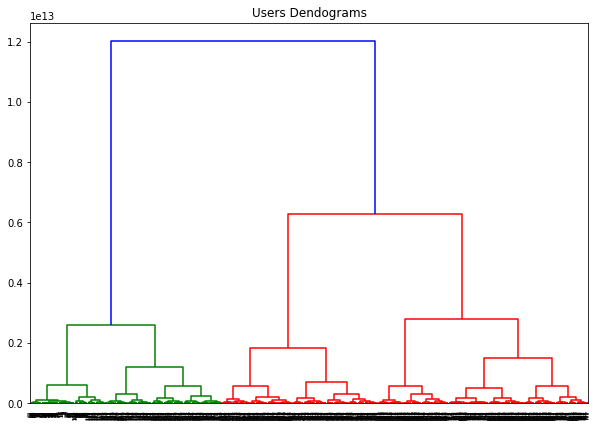

In [ ]:
plt.figure(figsize=(10, 7))
plt.title("Users Dendograms")
dend = shc.dendrogram(shc.linkage(data_hierarchichal , method='ward'))

In [ ]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters= 3, affinity='euclidean', linkage='ward')
cluster.fit_predict(data_hierarchichal)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

# Others

## Data dictionnary

- id
id	Int64	The integer representation of the unique identifier for this User. This number is greater than 53 bits and some programming languages may have difficulty/silent defects in interpreting it. Using a signed 64 bit integer for storing this identifier is safe. Use id_str to fetch the identifier to be safe. See Twitter IDs for more information. Example:
		 
		"id": 6253282

- name		 
name	String	The name of the user, as they’ve defined it. Not necessarily a person’s name. Typically capped at 50 characters, but subject to change. Example:
		 
		"name": "Twitter API"
- screen_name	 
screen_name	String	The screen name, handle, or alias that this user identifies themselves with. screen_names are unique but subject to change. Use id_str as a user identifier whenever possible. Typically a maximum of 15 characters long, but some historical accounts may exist with longer names. Example:
		 
		"screen_name": "twitterapi"
- location	 
location	String	Nullable . The user-defined location for this account’s profile. Not necessarily a location, nor machine-parseable. This field will occasionally be fuzzily interpreted by the Search service. Example:
		 
		"location": "San Francisco, CA"
- description		 
description	String	Nullable . The user-defined UTF-8 string describing their account. Example:
		 
		"description": "The Real Twitter API."
- verified		 
verified	Boolean	When true, indicates that the user has a verified account. See Verified Accounts . Example:
		 
		"verified": false
- followers_count		 
followers_count	Int	The number of followers this account currently has. Under certain conditions of duress, this field will temporarily indicate “0”. Example:
		 
		"followers_count": 21
- friends_count	 
friends_count	Int	The number of users this account is following (AKA their “followings”). Under certain conditions of duress, this field will temporarily indicate “0”. Example:
		 
		"friends_count": 32
- favourites_count	 
favourites_count	Int	The number of Tweets this user has liked in the account’s lifetime. British spelling used in the field name for historical reasons. Example:
		 
		"favourites_count": 13
- created_at		 
created_at	String	The UTC datetime that the user account was created on Twitter. Example:
		 
		"created_at": "Mon Nov 29 21:18:15 +0000 2010"
		 


 From https://developer.twitter.com/en/docs/twitter-api/v1/data-dictionary/overview/user-object

The Id is the integer representation of the unique identifier for a twitter user